<a href="https://colab.research.google.com/github/sgmurphy00/TOOLS1/blob/google_collab_environment/ART_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author: Paul Scheidt
# Description: Implement simple Machine Learning Classification Model for SAT6 Database
# Implement ART toolbox to perform poisoning attack

In [2]:
# Problem Definition


In [3]:
# Real-World Impact

In [4]:
# Dataset Description

Quality of Data and Preprocessing

In [5]:
# Required Python Libraries
from google.colab import drive
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# Libraries for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# Libraries for Visualizing Deeplearning Models
from IPython import display
from tensorflow.keras.utils import plot_model
%matplotlib inline

In [6]:
# Initializing data, developing train/test splits
# Connecting to Deep Stat Database
drive.mount('/content/drive')




Mounted at /content/drive


In [7]:
DATA_PATH = '/content/drive/My Drive/DEEPSAT6/'
# Initializing training and valiadation Data Paths
train_data_path = DATA_PATH + '/X_train_sat6.csv'
train_label_path = DATA_PATH + 'y_train_sat6.csv'
test_data_path = DATA_PATH + 'X_test_sat6.csv'
test_label_path = DATA_PATH + 'y_test_sat6.csv'

# Storing data into pandas dataframes
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

# Investigating Shape of Pandas DataFrame
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [8]:
# Restructuring Training and Test Images to be 3 layers, RGB
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

Text(0.5, 1.0, '0    0\n1    0\n2    0\n3    0\n4    0\n5    1\nName: 3, dtype: uint8')

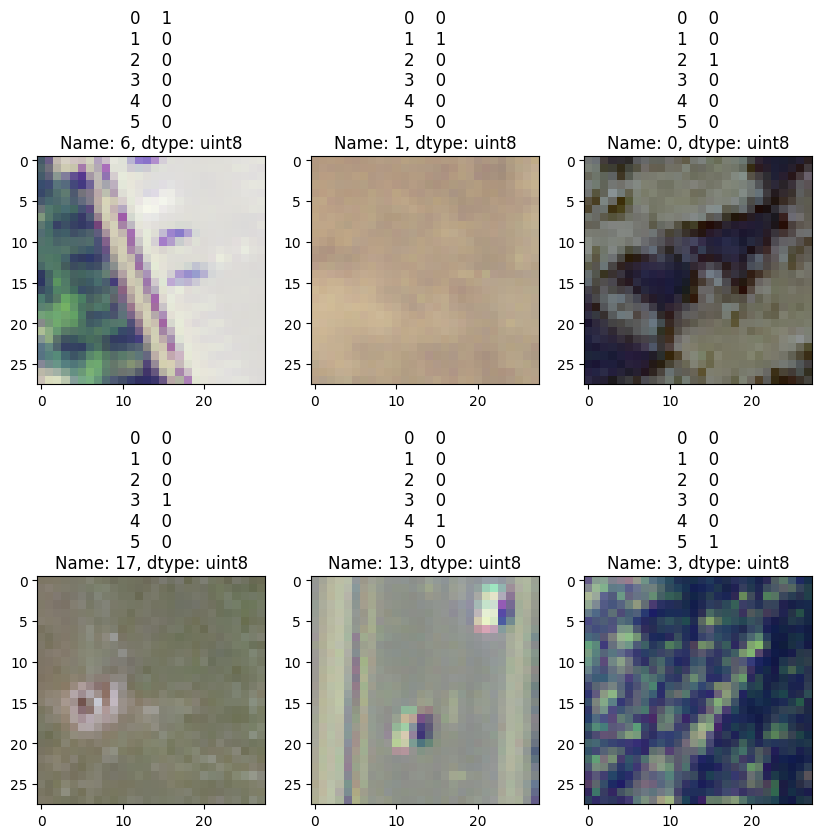

In [9]:
# This Code Block Highlights examples of images from each class


fig = plt.figure(figsize = (10,10))
rows = 2
cols = 3


# plotting Class A
ax1 = fig.add_subplot(rows, cols, 1)
img_A = x_train[6].reshape([28,28,4])[:,:,:3]
label_A = y_train.iloc[6]
plt.imshow(img_A)
ax1.set_title(label_A)

# Plotting Class B
ax2 = fig.add_subplot(rows, cols, 2)
img_B = x_train[1].reshape([28,28,4])[:,:,:3]
label_B = y_train.iloc[1]
plt.imshow(img_B)
ax2.set_title(label_B)

# plotting Class C
ax3 = fig.add_subplot(rows, cols, 3)
img_C = x_train[0].reshape([28,28,4])[:,:,:3]
label_C = y_train.iloc[0]
plt.imshow(img_C)
ax3.set_title(label_C)

# Plotting Class D
ax4 = fig.add_subplot(rows, cols, 4)
img_D = x_train[17].reshape([28,28,4])[:,:,:3]
label_D = y_train.iloc[17]
plt.imshow(img_D)
ax4.set_title(label_D)

# plotting Class E
ax5 = fig.add_subplot(rows, cols,5)
img_E = x_train[13].reshape([28,28,4])[:,:,:3]
label_E = y_train.iloc[13]
plt.imshow(img_E)
ax5.set_title(label_E)

# Plotting Class F
ax6 = fig.add_subplot(rows, cols, 6)
img_F = x_train[3].reshape([28,28,4])[:,:,:3]
label_F = y_train.iloc[3]
plt.imshow(img_F)
ax6.set_title(label_F)

In [10]:
# Insert Exploritory EDA

In [11]:
# Loading Pretrained Image Model

In [24]:
# Implementing Multi-Class, Classifier CNN in Tensor Flow
# Description: Implement traditional model, highlight model architecture, train and evaluate model performance

input = tf.keras.Input(shape=(28,28,4))
x = layers.Conv2D(filters=32,kernel_size=4,activation='relu')(input)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x= layers.Conv2D(filters=64,kernel_size=4,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
output = layers.Dense(6,activation='softmax')(x)

model = tf.keras.Model(inputs=input,outputs=output)
model.summary()


image_size = (28,28)


input = tf.keras.Input(shape=(28,28,4))
x = layers.Conv2D(28, 4, strides=(2, 2), padding='same',input_shape=image_size+(1,))(input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(4*2, 4, strides=(2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(4*4, 4, strides=(2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
class_output = tf.keras.layers.Dense(6,activation='softmax')(x)

model_discriminator= keras.Model(input, class_output)
model_discriminator.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 25, 25, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,886 (651.90 KB)

 Trainable params: 166,886 (651.90 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 28)          │           1,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 28)          │             112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 7, 7, 8)             │           3,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 8)             │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 4, 4, 16)            │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,354 (161.54 KB)

 Trainable params: 41,250 (161.13 KB)

 Non-trainable params: 104 (416.00 B)

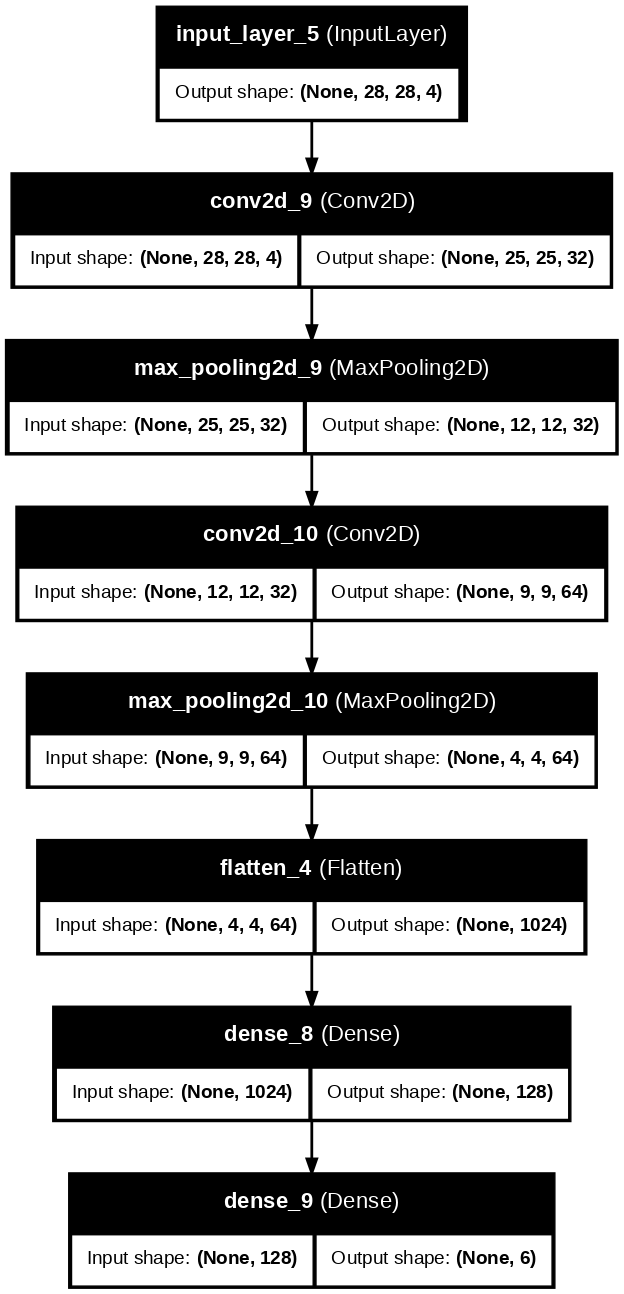

<Figure size 1000x1000 with 0 Axes>

In [25]:
# Displaying CNN Model
plt.figure(figsize=(10, 10))
plot_model(model, show_shapes=True, show_layer_names=True, dpi=100)


In [29]:
# Compiling Model


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])

history_baseline_model = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test,y_test))


Epoch 1/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9286 - loss: 0.1807 - val_accuracy: 0.9564 - val_loss: 0.1096
Epoch 2/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9519 - loss: 0.1244 - val_accuracy: 0.9537 - val_loss: 0.1190
Epoch 3/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9592 - loss: 0.1069 - val_accuracy: 0.9684 - val_loss: 0.0869
Epoch 4/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9634 - loss: 0.0964 - val_accuracy: 0.9741 - val_loss: 0.0754
Epoch 5/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9672 - loss: 0.0905 - val_accuracy: 0.9745 - val_loss: 0.0702
Epoch 6/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9698 - loss: 0.0837 - val_accuracy: 0.9749 - val_loss: 0.0727
Epoch 7/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9699 - loss: 0.0861 - val_accuracy: 0.9763 - val_loss: 0.0699
Epoch 8/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9695 - loss: 0

In [28]:
model_discriminator.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])

history_model_discriminator = model_discriminator.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test,y_test))


Epoch 1/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9487 - loss: 0.1364 - val_accuracy: 0.8408 - val_loss: 0.6045
Epoch 2/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9802 - loss: 0.0559 - val_accuracy: 0.9697 - val_loss: 0.0875
Epoch 3/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9849 - loss: 0.0425 - val_accuracy: 0.9526 - val_loss: 0.1311
Epoch 4/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9878 - loss: 0.0349 - val_accuracy: 0.9903 - val_loss: 0.0284
Epoch 5/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9888 - loss: 0.0322 - val_accuracy: 0.9868 - val_loss: 0.0392
Epoch 6/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9895 - loss: 0.0301 - val_accuracy: 0.9822 - val_loss: 0.0459
Epoch 7/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9904 - loss: 0.0277 - val_accuracy: 0.9651 - val_loss: 0.0979
Epoch 8/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9911 - loss: 0

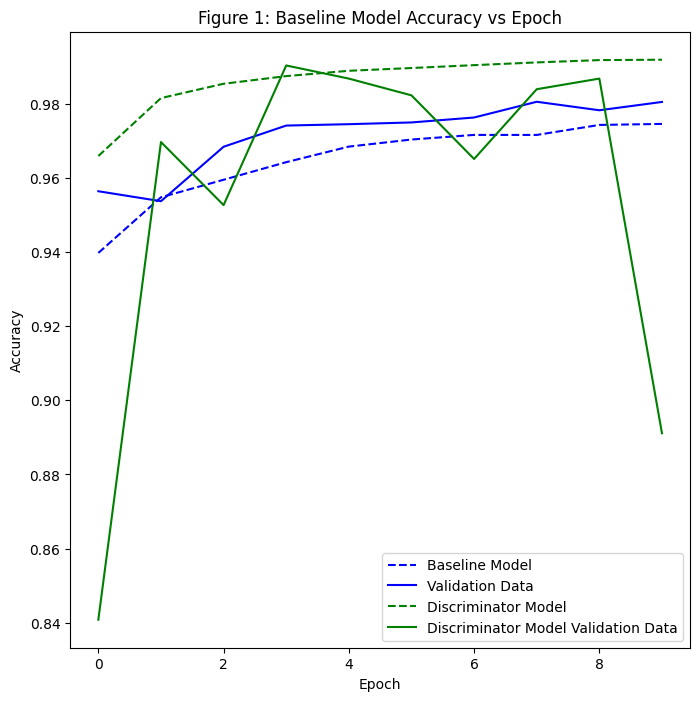

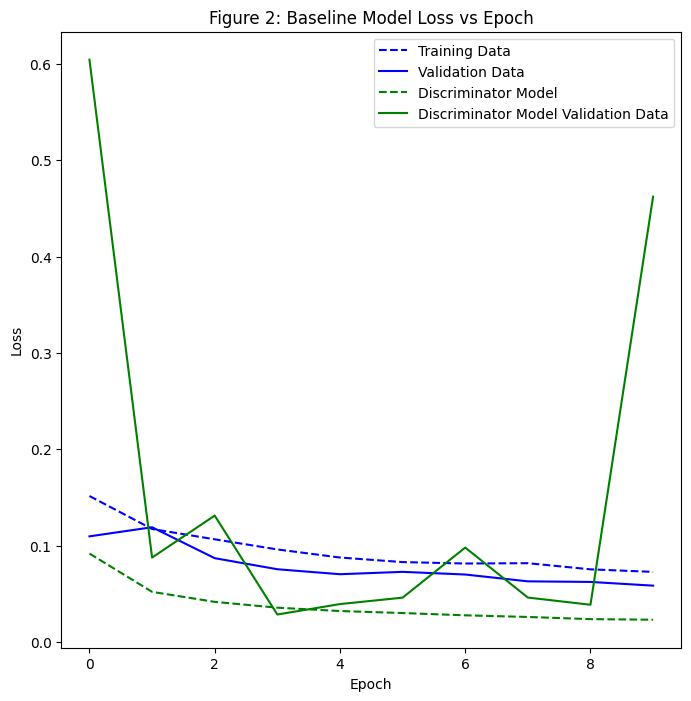

In [31]:
accuracy = plt.figure(figsize =(8, 8))

plt.plot(history_baseline_model.history['accuracy'],'b--',label='Baseline Model')
plt.plot(history_baseline_model.history['val_accuracy'],'b',label='Validation Data')
plt.plot(history_model_discriminator.history['accuracy'],'g--',label='Discriminator Model')
plt.plot(history_model_discriminator.history['val_accuracy'],'g',label='Discriminator Model Validation Data')
plt.title('Figure 1: Baseline Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

loss = plt.figure(figsize =(8, 8))
plt.plot(history_baseline_model.history['loss'],'b--',label='Training Data')
plt.plot(history_baseline_model.history['val_loss'],'b',label='Validation Data')
plt.plot(history_model_discriminator.history['loss'],'g--',label='Discriminator Model')
plt.plot(history_model_discriminator.history['val_loss'],'g',label='Discriminator Model Validation Data')
plt.title('Figure 2: Baseline Model Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Implementing ART-Toolbox, Data Poisoning